# Debiased metrics calculation example

**Table of Contents**

* Load and preprocess data: Kion
    * Train / test split
* What is debiasing of test interactions?
    * Original TEST items frequency distribution
    * Debiased TEST items frequency distribution
* Application of debiased metrics on Kion dataset
    * Prepare metrics
    * Prepare and fit models
    * Calculate and visualize metrics
* Metrics trade-off analysis: why do we need debiased metrics?
    * MAP vs Serendipity trade-off
    * Debiased MAP

`visuals` extension for `rectools` is required to run this notebook. You can install it with `pip install rectools[visuals]`  
`kaleido` pachage is required to render widgets outputs in png format. You can install it with `pip install kaleido`


In [23]:
import os
import threadpoolctl
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from rectools.metrics import MAP, calc_metrics, Serendipity
from rectools.models import ImplicitALSWrapperModel, PopularModel, ImplicitItemKNNWrapperModel
from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import debias_interactions, DebiasConfig, HitRate, AvgRecPopularity, Intersection
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import BM25Recommender

try:
    from rectools.visuals import MetricsApp
except ImportError:
    print("`visuals` extension for `rectools` is required. You can install it with `pip install rectools[visuals]`")

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15, 5)})
sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":14,
                            "xtick.labelsize": 14, "ytick.labelsize": 14})

# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

## Load and preprocess data: Kion

In [34]:
# %%time
# !wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip -O data_original.zip
# !unzip -o data_original.zip
# !rm data_original.zip

In [7]:
DATA_PATH = Path("data_original")

users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = (
    pd.read_csv(DATA_PATH / 'interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)
interactions[Columns.Weight] = 1

### Train / test split

In [8]:
max_date = interactions[Columns.Datetime].max()
train = interactions[interactions[Columns.Datetime] < max_date - pd.Timedelta(days=7)].copy()
test = interactions[interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=7)].copy()
cold_users = set(test[Columns.User]) - set(train[Columns.User])
test.drop(test[test[Columns.User].isin(cold_users)].index, inplace=True)
test_users = test[Columns.User].unique()
catalog=train[Columns.Item].unique()

# What is debiasing of test interactions?

### Original TEST items frequency distribution
Let's look at the TEST items frequency distribution lineplot and boxplot

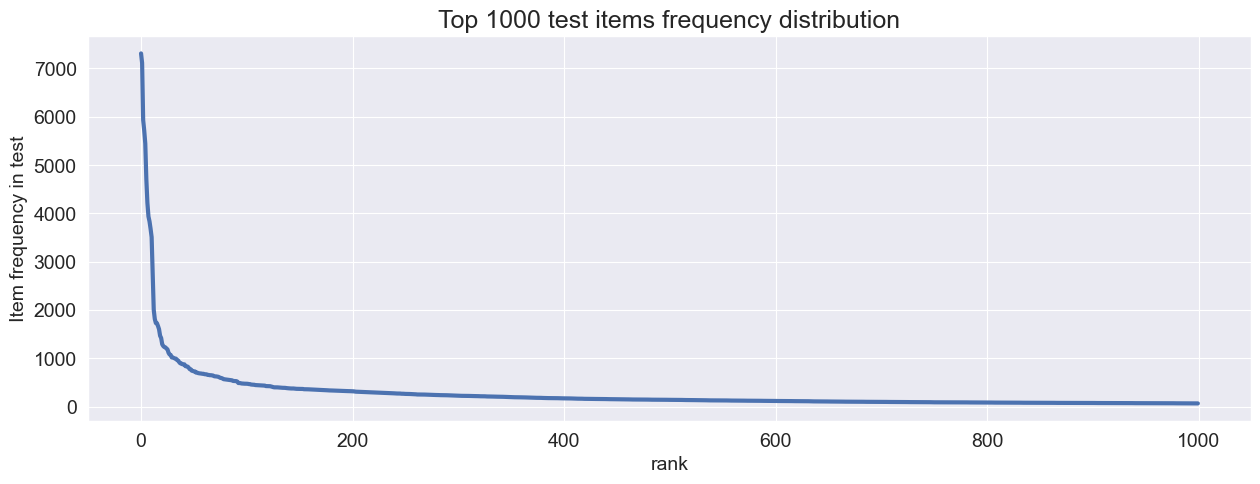

In [27]:
def plot_linelot(test, treshold = 150):
    item_test_counts = pd.DataFrame(test[Columns.Item].value_counts()).reset_index().sort_values("count", ascending=False)
    top_item_test_counts = item_test_counts.head(treshold)
    top_item_test_counts["rank"] = np.arange(treshold)
    bplot = sns.lineplot(data = top_item_test_counts, x = 'rank', 
                y = 'count', linewidth=3)
    bplot.set_title(f'Top {treshold} test items frequency distribution')
    bplot.set_ylabel('Item frequency in test')
    
plot_linelot(test, 1000)

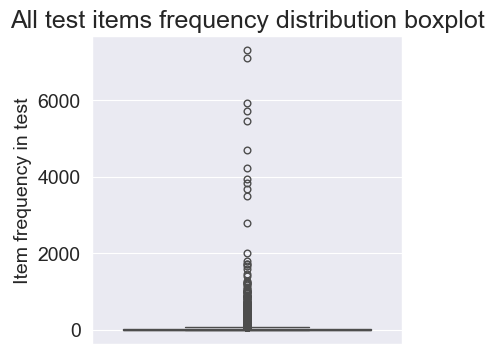

In [28]:
def plot_boxplot(test, color: str="blue"):
    plt.figure(figsize=(4,4))
    item_test_counts = pd.DataFrame(test[Columns.Item].value_counts()).reset_index().sort_values("count", ascending=False)
    boxplot = sns.boxplot(data = item_test_counts,
                y = 'count', color=color)
    boxplot.set_title(f'All test items frequency distribution boxplot')
    boxplot.set_ylabel('Item frequency in test')
    
    
plot_boxplot(test)

We have extreme outliers in test frequency. This is qutie common in many real life services data

**We don't want those extremely frequent OUTLIER test items to overwhelm our TruePositive based metrics**

This is the main idea under debias protocol for metrics computations.

All classification and ranking metrics will be exteremely sensitive to such test distributions. Models that often recommend overly-frequent test items will "win" on TruePositive based metrics.

### Debiased TEST items frequency distribution

What if we preprocess test interactions? Let's downsample TEST user interactions with overly-frequent items so that we will not have any outliers in test data?
Let's follow the boxplot logic and use Itra-Quartile Range for this.
For debiasing we can specify IQR coefficent to calulate the maximum allowed test item frequency. No item should have test interactions above this border. Just like in classic boxplot logic.

We are not changing train data at all. We just want to create a validation protocol that will not be affected by outliers in test.

In [11]:
# Downsample outliers item interactions from TEST using rectools
debiased_test = debias_interactions(test, config = DebiasConfig(iqr_coef = 1.5, random_state=32))

Let's see what' changed in TEST interactions after debiasing

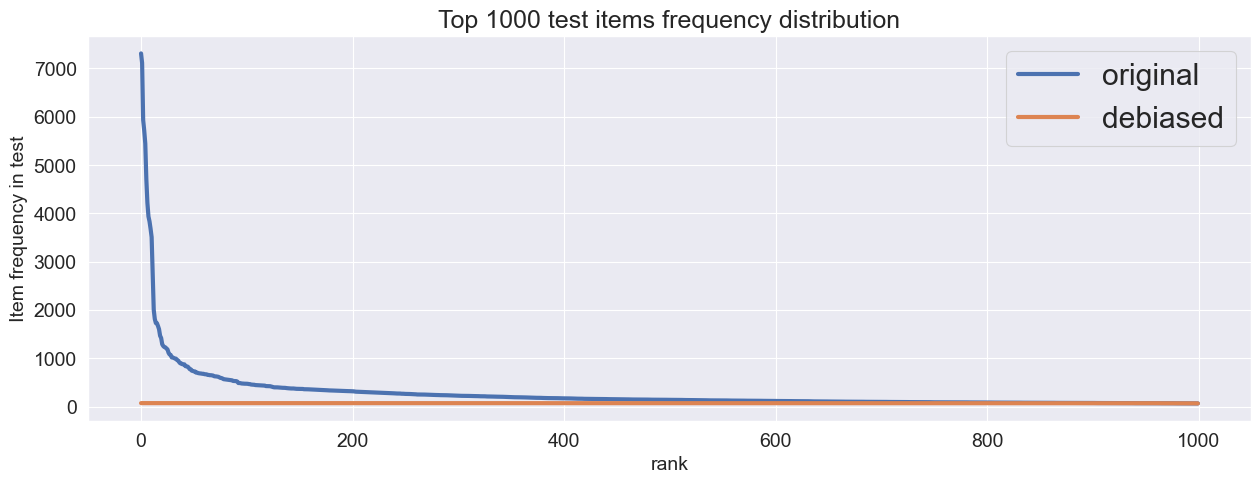

In [33]:
def plot_linelot_compared(test, debiased_test, treshold = 150):
    fig, ax = plt.subplots(ncols=1)
    item_test_counts = pd.DataFrame(test[Columns.Item].value_counts()).reset_index().sort_values("count", ascending=False)
    top_item_test_counts = item_test_counts.head(treshold)
    top_item_test_counts["rank"] = np.arange(treshold)
    bplot = sns.lineplot(data = top_item_test_counts, x = 'rank', 
                y = 'count', ax=ax, linewidth=3, label="original")
    bplot.set_title(f'Top {treshold} test items frequency distribution')
    bplot.set_ylabel('Item frequency in test')
    item_test_counts_deb = pd.DataFrame(debiased_test[Columns.Item].value_counts()).reset_index().sort_values("count", ascending=False)
    top_item_test_counts_deb = item_test_counts_deb.head(treshold)
    top_item_test_counts_deb["rank"] = np.arange(treshold)
    sns.lineplot(data = top_item_test_counts_deb, x = 'rank', 
                y = 'count', ax=ax, linewidth=3, label="debiased")
    plt.legend(fontsize='large')

plot_linelot_compared(test ,debiased_test, 1000)

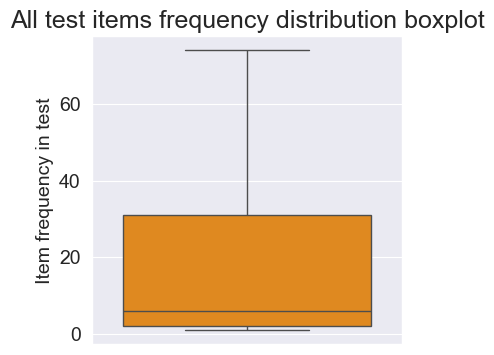

In [30]:
plot_boxplot(debiased_test, color="darkorange")

Now we have 2 variants of test inteactions: classic test and it's down-sampled, "debiased" version. We can calculate any TruePositive-based metric on any variant of test interactions. 

# Application of debiased metrics on Kion dataset
In rectools we have debias mechanism inside all of the appropriate metrics. So there is no need for manual debiasing of test interactions. 

To apply debiasing protocol during metrics calculation you just need to specify `debias_config` in metric's initialization.

## Prepare metrics

In [43]:
metrics = {
    'Pop bias': AvgRecPopularity(k=10, normalize=True),
    'Serendipity': Serendipity(k=10),
    'Hit rate': HitRate(k=10),
    'Intersection': Intersection(k=10),
    'Hit rate debiased': HitRate(k=10, debias_config = DebiasConfig(random_state=32, iqr_coef=5)),  # let's debias this one
    'MAP': MAP(k=10),
    'MAP_debiased': MAP(k=10, debias_config = DebiasConfig(random_state=32, iqr_coef=10)),  # let's debias this one
}

## Prepare and fit models

In [44]:
K_RECOS = 10
NUM_THREADS = 32
RANDOM_STATE = 32
ITERATIONS = 10

In [45]:
# Prepare ALS models

def make_als_model(factors: int, regularization: float=0.5, alpha: float=10, fit_features_together: bool=False):
    return ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            alpha=alpha,
            random_state=RANDOM_STATE,
            use_gpu=False,
            num_threads = NUM_THREADS,
            iterations=ITERATIONS),
        fit_features_together = fit_features_together,
    )
factors_options = (32, 64, 128)
als_models = {
    f"als_{factors}": make_als_model(factors) for factors in factors_options
}

In [60]:
# Prepare ItemKNN models

from itertools import product

k_options = (20, 200)
k1_options = (0.1, 3, 5)
b_options = (0.1,)

bm25_models = {
    f"bm25_{k}_{k1}_{b}": ImplicitItemKNNWrapperModel(
        BM25Recommender(k, k1, b)) for k, k1, b in product(k_options, k1_options, b_options)
}

In [61]:
# Prepare popular model

from datetime import timedelta
models = {"pop": PopularModel(period=timedelta(days=14))}
models.update(als_models)
models.update(bm25_models)
models

{'pop': <rectools.models.popular.PopularModel at 0x2981e77c0>,
 'als_32': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x296be9a80>,
 'als_64': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x296be9900>,
 'als_128': <rectools.models.implicit_als.ImplicitALSWrapperModel at 0x296b5f700>,
 'bm25_20_0.1_0.1': <rectools.models.implicit_knn.ImplicitItemKNNWrapperModel at 0x2981e4130>,
 'bm25_20_3_0.1': <rectools.models.implicit_knn.ImplicitItemKNNWrapperModel at 0x2981e6860>,
 'bm25_20_5_0.1': <rectools.models.implicit_knn.ImplicitItemKNNWrapperModel at 0x2981e6950>,
 'bm25_200_0.1_0.1': <rectools.models.implicit_knn.ImplicitItemKNNWrapperModel at 0x2981e6980>,
 'bm25_200_3_0.1': <rectools.models.implicit_knn.ImplicitItemKNNWrapperModel at 0x2981e72b0>,
 'bm25_200_5_0.1': <rectools.models.implicit_knn.ImplicitItemKNNWrapperModel at 0x2981e7a60>}

In [62]:
%%time
dataset = Dataset.construct(
    interactions_df=train,
)
for model in models.values():
    model.fit(dataset)

CPU times: user 3min 46s, sys: 3.59 s, total: 3min 49s
Wall time: 3min 53s


## Calculate and visualize metrics

In [64]:
recos = {
    model_name: model.recommend(k=10, users=test_users,dataset=dataset, filter_viewed=True) for model_name, model in models.items()
}
res = []
for model_name, reco in recos.items():
    model_metrics = calc_metrics(metrics, recos[model_name], test, train, catalog, ref_reco = {"pop": recos["pop"]})
    model_metrics.update({"model": model_name})
    res.append(model_metrics)
models_metrics = pd.DataFrame(res)

models_meta = [{"model": model_name,
                "model_type": model_name.split("_")[0]} for model_name in models.keys()]


In [74]:
# When you run this notebook, the output of this cell will have an interactive widget for metrics trade-off analysis

app = MetricsApp.construct(models_metrics, pd.DataFrame(models_meta))

# Metrics trade-off analysis: why do we need debiased metrics?
Let's take MAP as an example of a TruePositive based metrics. Logic will be the same for any other classification or ranking RecSys metric.

### MAP vs Serendipity trade-off
MAP and Serendipity usually have negative correlation for models that already show descent quality. 

To choose a model for usage in  real-life service it is necessary to choose a model that shows maximum MAP metric value (here it is `pop`, colored in green). Or a model that shows maximum Serendipity value (like `als_128` model, colored in blue).

Or look at the scatter-plot and choose some other model that is within pareto-optimal deсisions (like some of the bm-25 models coloured in red)

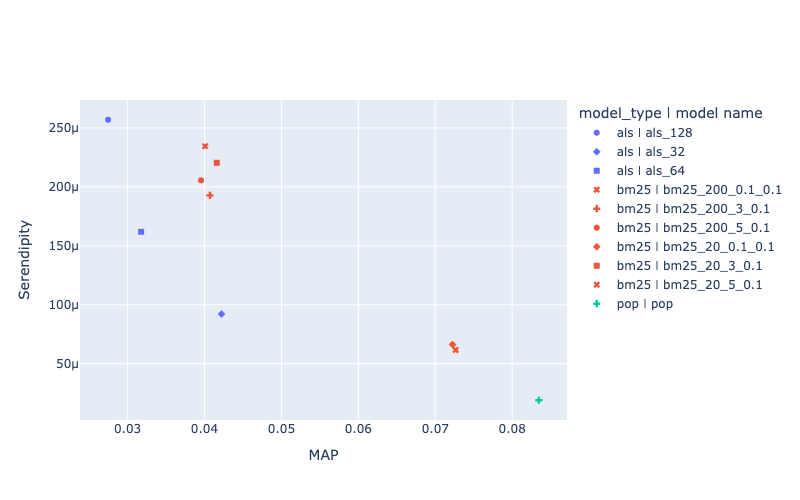

In [68]:
# Static report from the interactive `MetricsApp`
app.fig.show("png")

Choosing a model from pareto-optimal decisions sounds reasonble but it doesn't give a researher one single optimization goal.

### Debiased MAP

Debiased variant of metric (like debiased MAP) can serve as a single optimization goal for hyper-params  tuning and best model selection.
Models that are selected based on debiased metric value can be quite different from those that optimize origial metric (like MAP) and also quite different from those that optimize Serendipity.

On the picture below the red-colored `bm25` model has the highest debiased MAP value. It could be declared a winner based on this level of down-sampling of test interactions if it is chosen as optimal for the service.

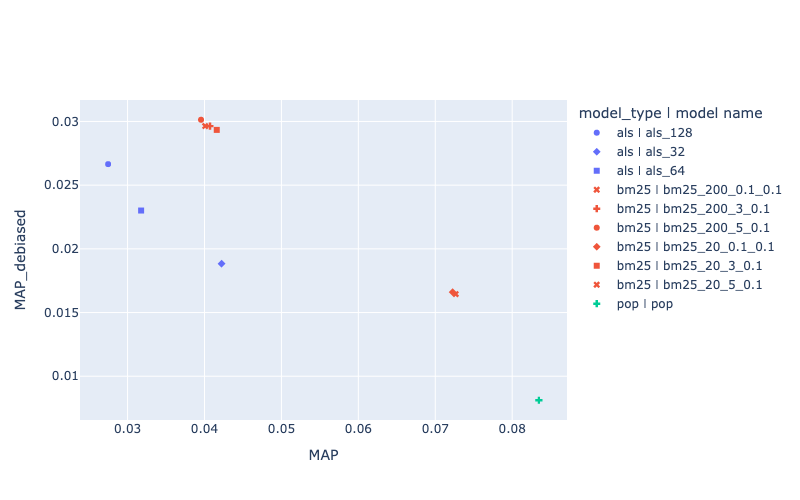

In [69]:
# Static report from the interactive `MetricsApp`
app.fig.show("png")